In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score
import os
from dotenv import load_dotenv
import yfinance as yf
import pandas as pd
import pandas_ta as ta
from scikeras.wrappers import KerasRegressor
# Load environment variables from the .env file
load_dotenv('../.env');

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import requests
import csv
from itertools import permutations
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
from ta import add_all_ta_features
from sklearn.linear_model import LinearRegression

def load_and_prepare(ticker, start_date, end_date):
    # Fetch historical stock data
    df = yf.download(ticker, start=start_date , end=end_date)

    # Calculate daily returns
    df['returns'] = df['Adj Close'].pct_change()

    # Fetch market data (e.g., S&P 500)
    market_data = yf.download('^GSPC', start=df.index.min(), end=df.index.max())
    market_data['market_returns'] = market_data['Adj Close'].pct_change()

    # Combine stock and market data
    merged_data = pd.merge(df, market_data[['market_returns']], left_index=True, right_index=True, how='inner')

    # Drop rows with missing values
    merged_data.dropna(inplace=True)

    # Initialize lists to store alpha and beta values
    alpha_values = []
    beta_values = []

    # Set up X and y for linear regression
    X = merged_data['market_returns'].values.reshape(-1, 1)
    y = merged_data['returns'].values

    # Iterate through the data to calculate alpha and beta for each day
    for i in range(len(merged_data)):
        X_i = X[:i + 1]
        y_i = y[:i + 1]

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X_i, y_i)

        # Extract alpha and beta for the current day
        alpha_i = model.intercept_
        beta_i = model.coef_[0]

        alpha_values.append(alpha_i)
        beta_values.append(beta_i)

    # Add alpha and beta columns to the DataFrame
    merged_data['alpha'] = alpha_values
    merged_data['beta'] = beta_values

    # Drop columns not needed for the final result
    merged_data.drop(['returns', 'market_returns'], axis=1, inplace=True)

    # Add technical analysis features
    merged_data = add_all_ta_features(merged_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

    # Calculate target and target class
    merged_data['target'] = ((merged_data['Close'] - merged_data['Open']) / merged_data['Open']) * 100
    merged_data['target'] = merged_data['target'].shift(-1)
 
    merged_data['target_class'] = np.where(merged_data['target'] < 0, 0, 1)
    
    merged_data['target_next_close'] = merged_data['Close'].shift(-1)

    # Drop rows with missing values
    merged_data.dropna(inplace=True)

    return merged_data




In [3]:

stock_data = load_and_prepare('AMZN', "2010-01-01" , "2024-01-01")
stock_data.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,alpha,beta,volume_adi,volume_obv,...,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,target,target_class,target_next_close
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,6.6715,6.7740,6.5905,6.7345,6.7345,177038000,0.005900,0.000000,1.008197e+08,177038000,...,0.0,0.000000,0.000000,0.000000,-89.367267,0.000000,0.000000,-1.745911,0,6.6125
2010-01-06,6.7300,6.7365,6.5825,6.6125,6.6125,143576000,-0.023213,9.343998,1.318283e+07,33462000,...,0.0,-1.529184,-0.305837,-1.223347,-1.811563,-1.828173,-1.811563,-1.522614,0,6.5000
2010-01-07,6.6005,6.6160,6.4400,6.5000,6.5000,220604000,-0.015721,2.340360,-5.700959e+07,-187142000,...,0.0,0.794747,-0.085720,0.880467,-1.701326,-1.715965,-3.482069,2.267161,1,6.6760
2010-01-08,6.5280,6.6840,6.4515,6.6760,6.6760,196610000,-0.010286,3.698064,1.260704e+08,9468000,...,0.0,1.496374,0.230699,1.265675,2.707694,2.671685,-0.868659,-1.741818,0,6.5155
2010-01-11,6.6310,6.6400,6.4605,6.5155,6.5155,175588000,-0.019269,5.707451,5.808564e+07,-166120000,...,0.0,1.100510,0.404661,0.695849,-2.404135,-2.433506,-3.251910,-1.271420,0,6.3675


In [4]:
stock_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'alpha', 'beta',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_mfi',
       'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', '

In [5]:
df = stock_data

In [24]:
df.isna().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
                    ..
others_dlr           0
others_cr            0
target               0
target_class         0
target_next_close    0
Length: 94, dtype: int64

In [25]:
from sklearn.model_selection import train_test_split

# Assuming X is your feature set and y is your target variable
X = df.drop(['Open', 'High', 'Low', 'Close', 'Volume','target',
       'target_class', 'target_next_close'], axis=1)# Adjust columns accordingly

y = df[['target_class']]  # Adjust the target variable accordingly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 , random_state=42)


In [8]:
from sklearn.model_selection import train_test_split

2024-01-16 14:06:51.624676: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-16 14:06:51.624841: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-16 14:06:51.625681: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-16 14:06:51.626405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-16 14:06:51.627134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/50


2024-01-16 14:06:54.229781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


88/88 [==============================] - 11s 41ms/step - loss: 0.0671 - val_loss: 0.0247
Epoch 2/50
88/88 [==============================] - 1s 12ms/step - loss: 0.0131 - val_loss: 0.0077
Epoch 3/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 4/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 5/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 6/50
88/88 [==============================] - 1s 12ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 7/50
88/88 [==============================] - 1s 12ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 8/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 9/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 10/50
88/88 [==============================] - 1s 13ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 11/50
88/88 [

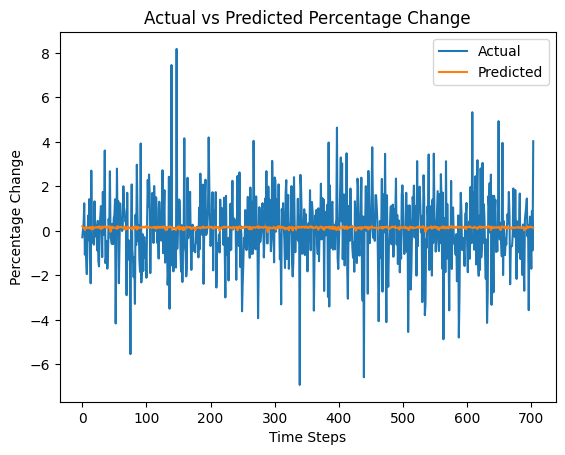

In [9]:


# Extract features and target variable
features = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Adjust columns accordingly
target = stock_data['target'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)

# Reshape the data for LSTM input (samples, time steps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)

# Make predictions on the test set
test_predictions_scaled = model.predict(X_test_lstm)

# Inverse transform the predictions and actual values for comparison
test_predictions = scaler.inverse_transform(test_predictions_scaled)
y_test_inv = scaler.inverse_transform(y_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inv, test_predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Plot actual vs predicted values for the test set
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions, label='Predicted')
plt.title('Actual vs Predicted Percentage Change')
plt.xlabel('Time Steps')
plt.ylabel('Percentage Change')
plt.legend()
plt.show()


In [10]:
# Check the scale of the features
print("Feature Scale (min, max):", scaler.data_min_, scaler.data_max_)

# Check the scale of the target variable
print("Target Scale (min, max):", scaler.data_min_[0], scaler.data_max_[0])

Feature Scale (min, max): [-8.56145541] [12.21561051]
Target Scale (min, max): -8.561455407954012 12.21561051269018


The target variable's scale (min, max) is approximately (-8.56, 12.22). The MSE is a measure of how well your model's predictions align with the actual values. Since the MSE is a squared error, its scale is influenced by the scale of the target variable.

With a target variable scale of approximately (-8.56, 12.22), an MSE of 2.719 suggests that, on average, our model's predictions have an error of around 1.65 (square root of 2.719) in the original scale.

Keeping in mind that the interpretation of MSE depends on the scale of our target variable. Lower MSE values are generally better, indicating better model performance in terms of reducing prediction errors. 